This notebook is created in order to get familiar with ntlk and NLP workflows

In [94]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from nltk.corpus import stopwords
from nltk.util import ngrams
from sklearn.feature_extraction.text import CountVectorizer
from collections import defaultdict
from collections import  Counter
plt.style.use('ggplot')
stop=set(stopwords.words('english'))
import re
from nltk.tokenize import word_tokenize
import gensim
import string
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tqdm import tqdm
from keras.models import Sequential
from keras.layers import Embedding,LSTM,Dense,SpatialDropout1D
from keras.initializers import Constant
from sklearn.model_selection import train_test_split
from keras.optimizers import Adam
import os 
import tensorflow as tf

some part of the code in this not book is from

-https://www.kaggle.com/gunesevitan/nlp-with-disaster-tweets-eda-cleaning-and-bert/data

-https://www.kaggle.com/shahules/basic-eda-cleaning-and-glove/data

## Load the data


In [95]:
train_tweet= pd.read_csv('../input/nlp-getting-started/train.csv')
test_tweet=pd.read_csv('../input/nlp-getting-started/test.csv')

## Some example of the traning set

In [96]:
train_tweet.head(10)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
5,8,NaN,NaN,#RockyFire Update => California Hwy. 20 closed...,1
6,10,NaN,NaN,#flood #disaster Heavy rain causes flash flood...,1
7,13,NaN,NaN,I'm on top of the hill and I can see a fire in...,1
8,14,NaN,NaN,There's an emergency evacuation happening now ...,1
9,15,NaN,NaN,I'm afraid that the tornado is coming to our a...,1


## Some example of the test set

In [97]:
test_tweet.head(10)

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan
5,12,NaN,NaN,We're shaking...It's an earthquake
6,21,NaN,NaN,They'd probably still show more life than Arse...
7,22,NaN,NaN,Hey! How are you?
8,27,NaN,NaN,What a nice hat?
9,29,NaN,NaN,Fuck off!


In [98]:
print('Training set has {} rows and {} columns'.format(train_tweet.shape[0],train_tweet.shape[1]))
print('Test set has {} rows and {} columns'.format(test_tweet.shape[0],test_tweet.shape[1]))

Training set has 7613 rows and 5 columns
Test set has 3263 rows and 4 columns


# EDA

## Number of non-disaster tweet vs disaster tweet

Text(0, 0.5, 'samples')

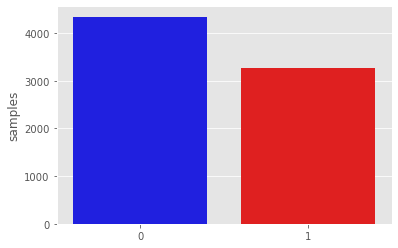

In [99]:
samples = train_tweet.target.value_counts()
sns.barplot(x =samples.index,y = samples, palette = ['blue','red'])
plt.gca().set_ylabel('samples')

0 represents non-disaster tweets, where 1 represents disaster tweets

As you can see from the plot above, the dataset has more 0 than 1 but not significantly.

## keywords distribution on non-disaster tweets vs disaster tweets

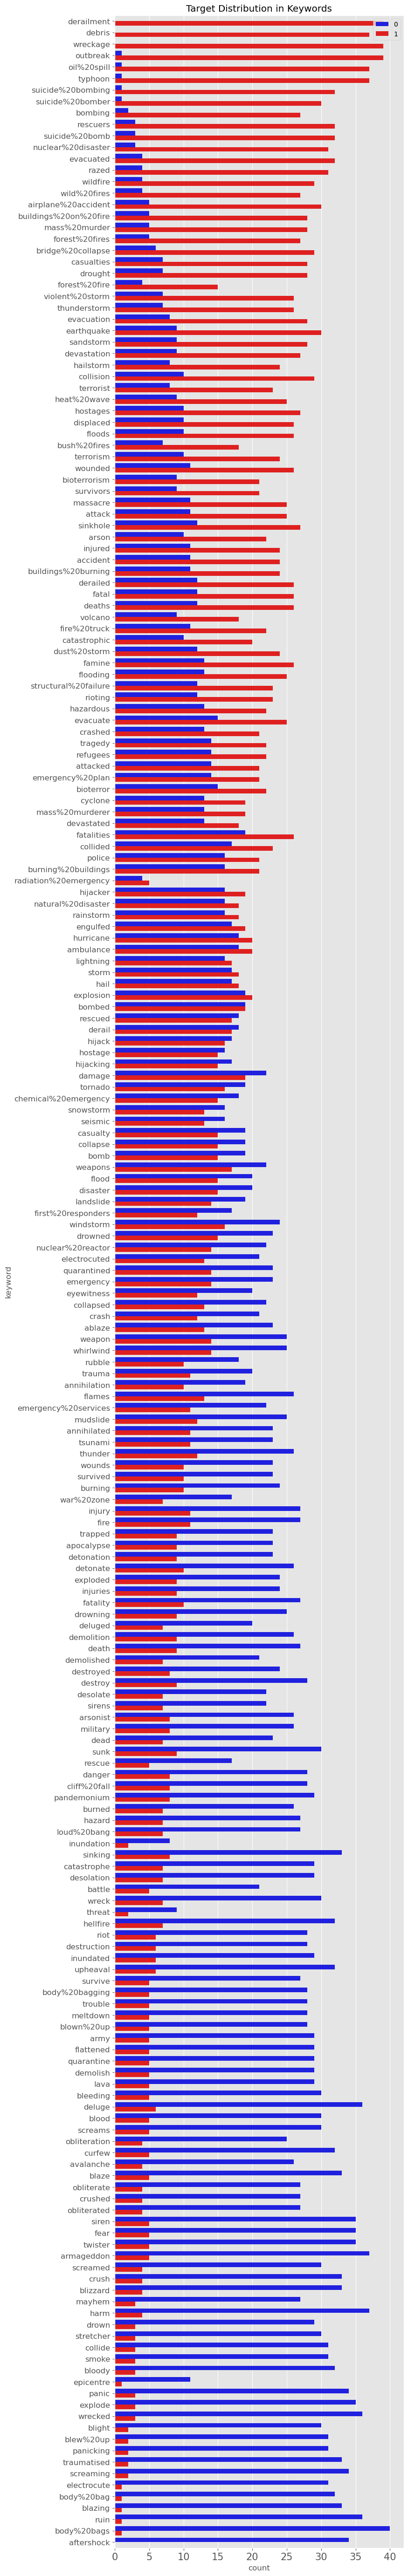

In [100]:
train_tweet['target_mean'] = train_tweet.groupby('keyword')['target'].transform('mean')

fig = plt.figure(figsize=(8, 72), dpi=100)

sns.countplot(y=train_tweet.sort_values(by='target_mean', ascending=False)['keyword'],
              hue=train_tweet.sort_values(by='target_mean', ascending=False)['target'],palette = ['blue','red'])

plt.tick_params(axis='x', labelsize=15)
plt.tick_params(axis='y', labelsize=12)
plt.legend(loc=1)
plt.title('Target Distribution in Keywords')

plt.show()

train_tweet.drop(columns=['target_mean'], inplace=True)

# Basic EDA

let's visualize distributions of some meta features in the tweets

## number of words

In [101]:
# word_count
DISASTER_TWEETS = train_tweet['target'] == 1
train_tweet['word_count'] = train_tweet['text'].apply(lambda x: len(str(x).split()))
test_tweet['word_count'] = test_tweet['text'].apply(lambda x: len(str(x).split()))

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

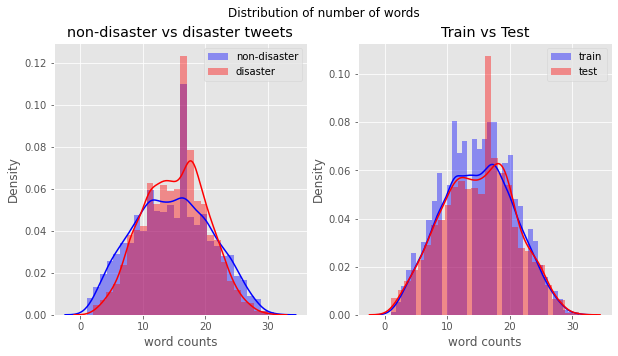

In [102]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
sns.distplot(train_tweet.loc[~DISASTER_TWEETS]['word_count'], label='non-disaster',ax=ax1,color='blue')
sns.distplot(train_tweet.loc[DISASTER_TWEETS]['word_count'], label='disaster',ax=ax1,color='red')
sns.distplot(train_tweet['word_count'], label='train',ax=ax2,color='blue')
sns.distplot(test_tweet['word_count'], label='test',ax=ax2,color='red')
ax1.set_xlabel('word counts')
ax2.set_xlabel('word counts')
fig.suptitle('Distribution of number of words')
ax1.set_title('non-disaster vs disaster tweets')
ax2.set_title('Train vs Test')
ax1.legend()
ax2.legend()
plt.show()

In [103]:
train_tweet.drop(columns=['word_count'], inplace=True)
test_tweet.drop(columns=['word_count'], inplace=True)

## number of unique words

In [104]:
# unique_word_count
train_tweet['unique_word_count'] = train_tweet['text'].apply(lambda x: len(set(str(x).split())))
test_tweet['unique_word_count'] = test_tweet['text'].apply(lambda x: len(set(str(x).split())))

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

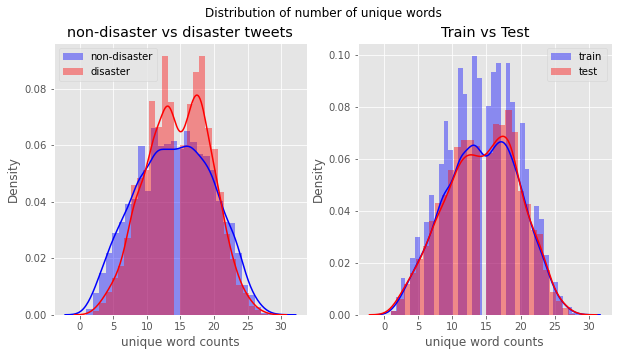

In [105]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
sns.distplot(train_tweet.loc[~DISASTER_TWEETS]['unique_word_count'], label='non-disaster',ax=ax1,color='blue')
sns.distplot(train_tweet.loc[DISASTER_TWEETS]['unique_word_count'], label='disaster',ax=ax1,color='red')
sns.distplot(train_tweet['unique_word_count'], label='train',ax=ax2,color='blue')
sns.distplot(test_tweet['unique_word_count'], label='test',ax=ax2,color='red')
ax1.set_xlabel('unique word counts')
ax2.set_xlabel('unique word counts')
fig.suptitle('Distribution of number of unique words')
ax1.set_title('non-disaster vs disaster tweets')
ax2.set_title('Train vs Test')
ax1.legend()
ax2.legend()
plt.show()

In [106]:
train_tweet.drop(columns=['unique_word_count'], inplace=True)
test_tweet.drop(columns=['unique_word_count'], inplace=True)

## number of stop words

In [107]:
# stop_word_count
train_tweet['stop_word_count'] = train_tweet['text'].apply(lambda x: len([w for w in str(x).lower().split() if w in stop]))
test_tweet['stop_word_count'] = test_tweet['text'].apply(lambda x: len([w for w in str(x).lower().split() if w in stop]))


/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

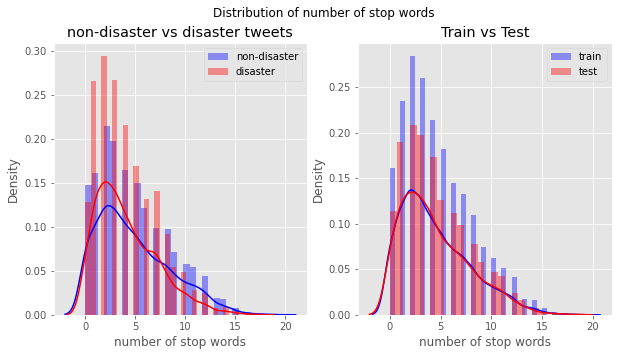

In [108]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
sns.distplot(train_tweet.loc[~DISASTER_TWEETS]['stop_word_count'], label='non-disaster',ax=ax1,color='blue')
sns.distplot(train_tweet.loc[DISASTER_TWEETS]['stop_word_count'], label='disaster',ax=ax1,color='red')
sns.distplot(train_tweet['stop_word_count'], label='train',ax=ax2,color='blue')
sns.distplot(test_tweet['stop_word_count'], label='test',ax=ax2,color='red')
ax1.set_xlabel('number of stop words')
ax2.set_xlabel('number of stop words')
fig.suptitle('Distribution of number of stop words')
ax1.set_title('non-disaster vs disaster tweets')
ax2.set_title('Train vs Test')
ax1.legend()
ax2.legend()
plt.show()

In [109]:
train_tweet.drop(columns=['stop_word_count'], inplace=True)
test_tweet.drop(columns=['stop_word_count'], inplace=True)

let' see what is the top 10 stop words in the training tweet for each class

In [110]:
def make_corpus(target):
    corpus=[]
    
    for x in train_tweet[train_tweet['target']==target]['text'].str.split():
        for i in x:
            corpus.append(i)
    return corpus

class 0 (non-disaster)

<BarContainer object of 10 artists>

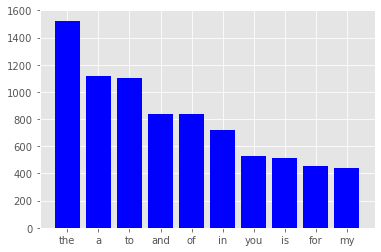

In [111]:
corpus0=make_corpus(0)

d0=dict()
for word in corpus0:
    if word in stop:
        freq = d0.get(word,0)+1
        d0[word]=freq
        
top=sorted(d0.items(), key=lambda x:x[1],reverse=True)[:10] 
x,y=zip(*top)
plt.bar(x,y,color='blue')

class 1 (non-disaster)

<BarContainer object of 10 artists>

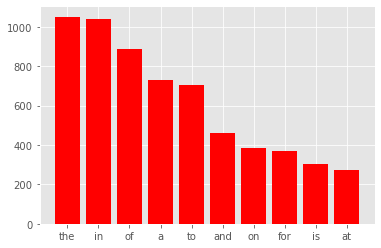

In [112]:
corpus0=make_corpus(1)

d0=dict()
for word in corpus0:
    if word in stop:
        freq = d0.get(word,0)+1
        d0[word]=freq
        
top=sorted(d0.items(), key=lambda x:x[1],reverse=True)[:10] 
x,y=zip(*top)
plt.bar(x,y,color='red')

## number of punctuations

In [113]:
train_tweet['punctuation_count'] = train_tweet['text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))
test_tweet['punctuation_count'] = test_tweet['text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))


/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

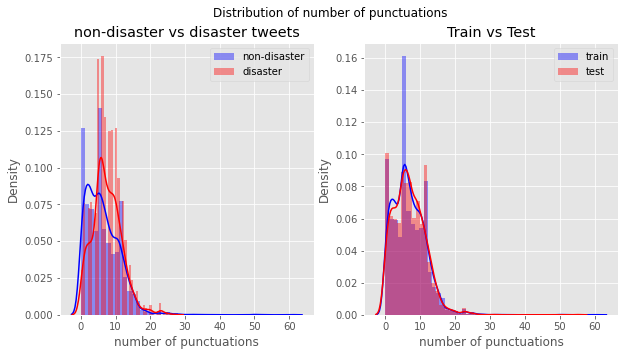

In [114]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
sns.distplot(train_tweet.loc[~DISASTER_TWEETS]['punctuation_count'], label='non-disaster',ax=ax1,color='blue')
sns.distplot(train_tweet.loc[DISASTER_TWEETS]['punctuation_count'], label='disaster',ax=ax1,color='red')
sns.distplot(train_tweet['punctuation_count'], label='train',ax=ax2,color='blue')
sns.distplot(test_tweet['punctuation_count'], label='test',ax=ax2,color='red')
ax1.set_xlabel('number of punctuations')
ax2.set_xlabel('number of punctuations')
fig.suptitle('Distribution of number of punctuations')
ax1.set_title('non-disaster vs disaster tweets')
ax2.set_title('Train vs Test')
ax1.legend()
ax2.legend()
plt.show()

In [115]:
train_tweet.drop(columns=['punctuation_count'], inplace=True)
test_tweet.drop(columns=['punctuation_count'], inplace=True)

let' see what is the top 15 punctuations in the training tweet for each class

let's start with class 0

<BarContainer object of 15 artists>

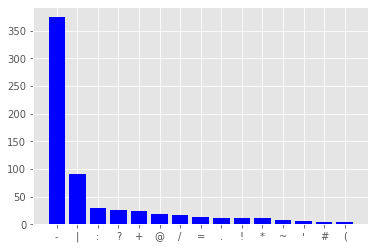

In [116]:
corpus0=make_corpus(0)
d0=dict()
for word in corpus0:
    if word in string.punctuation:
        freq = d0.get(word,0)+1
        d0[word]=freq
        
top=sorted(d0.items(), key=lambda x:x[1],reverse=True)[:15] 
x,y=zip(*top)
plt.bar(x,y,color='blue')

and then class 1

<BarContainer object of 15 artists>

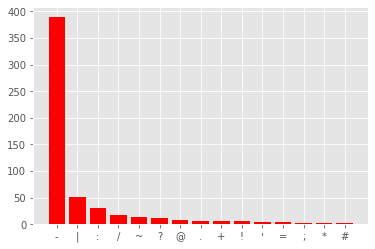

In [117]:
corpus0=make_corpus(1)

d0=dict()
for word in corpus0:
    if word in string.punctuation:
        freq = d0.get(word,0)+1
        d0[word]=freq
        
top=sorted(d0.items(), key=lambda x:x[1],reverse=True)[:15] 
x,y=zip(*top)
plt.bar(x,y,color='red')

# Data Cleaning

let's do some basic cleaning before we perform bigram analysis !

In [118]:
tweet=pd.concat([train_tweet,test_tweet])
tweet.shape

(10876, 5)

## removing punctuations

In [119]:
def remove_punct(text):
    table=str.maketrans('','',string.punctuation)
    return text.translate(table)

example="I am happy ^^ #yeah"
print(remove_punct(example))

I am happy  yeah


In [120]:
tweet['text']=tweet['text'].apply(lambda x : remove_punct(x))

## removing URLs

In [121]:
def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)



In [122]:
tweet['text']=tweet['text'].apply(lambda x : remove_URL(x))

## removing HTML

In [123]:
example = """<\pi>what is going on <dev>"""

In [124]:
def remove_html(text):
    html=re.compile(r'<.*?>')
    return html.sub(r'',text)
print(remove_html(example))

what is going on 


In [125]:
tweet['text']=tweet['text'].apply(lambda x : remove_html(x))

## correct the spellings

In [126]:
!pip install pyspellchecker

In [127]:
from spellchecker import SpellChecker
spell = SpellChecker()
def correct_spellings(text):
    corrected_text = []
    misspelled_words = spell.unknown(text.split())
    for word in text.split():
        if word in misspelled_words:
            corrected_text.append(spell.correction(word))
        else:
            corrected_text.append(word)
    return " ".join(corrected_text)
        
text = "I am too slepy, i need to dleep now"
correct_spellings(text)

'I am too slept i need to sleep now'

In [128]:
#tweet['text']=tweet['text'].apply(lambda x : correct_spellings(x))

Removing Emojis

In [129]:
# Reference : https://gist.github.com/slowkow/7a7f61f495e3dbb7e3d767f97bd7304b
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)


In [130]:
tweet['text']=tweet['text'].apply(lambda x : remove_emoji(x))

# Word representation with GloVe

For word representation we will use GloVe pretrained corpus model.

In [131]:
def create_corpus(df): #we will filter out stop words while we create the corpus.
    corpus=[]
    for tweet in tqdm(df['text']): #tqdm is used to follow the progress bar.
        words=[word.lower() for word in word_tokenize(tweet) if((word.isalpha()==1) & (word not in stop))]
        corpus.append(words)
    return corpus

In [132]:
corpus=create_corpus(tweet)

100%|██████████| 10876/10876 [00:02<00:00, 4544.50it/s]


In [133]:
#create embedding dict.
embedding_dict={}
with open('../input/glove-global-vectors-for-word-representation/glove.6B.100d.txt','r') as f:
    for line in f:
        values=line.split()
        word=values[0]
        vectors=np.asarray(values[1:],'float32')
        embedding_dict[word]=vectors
f.close()

In [134]:
MAX_LEN=50
tokenizer1=Tokenizer()
tokenizer1.fit_on_texts(corpus)
sequences=tokenizer1.texts_to_sequences(corpus)
padded_tweet=pad_sequences(sequences,maxlen=MAX_LEN,truncating='post',padding='post')

let's visualize how word_index looks like ! It is a dict of (word:index)

In [135]:
word_index

{'i': 1,
 'the': 2,
 'like': 3,
 'amp': 4,
 'im': 5,
 'a': 6,
 'fire': 7,
 'get': 8,
 'new': 9,
 'via': 10,
 'news': 11,
 'people': 12,
 'one': 13,
 'in': 14,
 'dont': 15,
 'us': 16,
 'emergency': 17,
 'video': 18,
 'disaster': 19,
 'would': 20,
 'this': 21,
 'to': 22,
 'police': 23,
 'still': 24,
 'is': 25,
 'got': 26,
 'you': 27,
 'my': 28,
 'suicide': 29,
 'body': 30,
 'crash': 31,
 'burning': 32,
 'first': 33,
 'storm': 34,
 'rt': 35,
 'attack': 36,
 'time': 37,
 'back': 38,
 'know': 39,
 'california': 40,
 'fires': 41,
 'buildings': 42,
 'see': 43,
 'going': 44,
 'and': 45,
 'man': 46,
 'love': 47,
 'day': 48,
 'two': 49,
 'world': 50,
 'cant': 51,
 'bomb': 52,
 'if': 53,
 'nuclear': 54,
 'full': 55,
 'go': 56,
 'hiroshima': 57,
 'dead': 58,
 'youtube': 59,
 'watch': 60,
 'today': 61,
 'life': 62,
 'think': 63,
 'car': 64,
 'train': 65,
 'last': 66,
 'killed': 67,
 'it': 68,
 'accident': 69,
 'its': 70,
 'good': 71,
 'of': 72,
 'say': 73,
 'we': 74,
 'make': 75,
 'war': 76,
 'no':

In [136]:
word_index=tokenizer1.word_index
num_words=len(word_index)+1
embedding_matrix=np.zeros((num_words,100))

for word,i in tqdm(word_index.items()):
    emb_vec=embedding_dict.get(word)
    if emb_vec is not None:
        embedding_matrix[i]=emb_vec

100%|██████████| 21444/21444 [00:00<00:00, 412501.51it/s]


## Model and Train

In [137]:
model=Sequential()

embedding=Embedding(num_words,100,embeddings_initializer=Constant(embedding_matrix),
                   input_length=MAX_LEN,trainable=False)

model.add(embedding)
model.add(SpatialDropout1D(0.25))
model.add(LSTM(64, dropout=0.25, recurrent_dropout=0.25))
model.add(Dense(1, activation='sigmoid'))
optimzer=Adam(learning_rate=1e-4)
model.compile(loss='binary_crossentropy',optimizer=optimzer,metrics=['accuracy'])

In [138]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 50, 100)           2144500   
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 50, 100)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                42240     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 2,186,805
Trainable params: 42,305
Non-trainable params: 2,144,500
_________________________________________________________________


In [139]:
#after data preprocessing, seperate train and test.
train=padded_tweet[:train_tweet.shape[0]]
test=padded_tweet[train_tweet.shape[0]:]

In [140]:
#split train and validation set
X_train,X_val,y_train,y_val=train_test_split(train,train_tweet['target'].values,test_size=0.15)

In [141]:
history=model.fit(X_train,y_train,batch_size=4,epochs=15,validation_data=(X_val,y_val),verbose=2)

Epoch 1/15
1618/1618 - 296s - loss: 0.5535 - accuracy: 0.7311 - val_loss: 0.4883 - val_accuracy: 0.7793
Epoch 2/15
1618/1618 - 293s - loss: 0.4922 - accuracy: 0.7792 - val_loss: 0.4649 - val_accuracy: 0.7986
Epoch 3/15
1618/1618 - 293s - loss: 0.4781 - accuracy: 0.7881 - val_loss: 0.4945 - val_accuracy: 0.7837
Epoch 4/15
1618/1618 - 290s - loss: 0.4747 - accuracy: 0.7855 - val_loss: 0.4630 - val_accuracy: 0.7977
Epoch 5/15
1618/1618 - 291s - loss: 0.4652 - accuracy: 0.7901 - val_loss: 0.4553 - val_accuracy: 0.8012
Epoch 6/15
1618/1618 - 292s - loss: 0.4611 - accuracy: 0.7940 - val_loss: 0.4526 - val_accuracy: 0.7951
Epoch 7/15
1618/1618 - 291s - loss: 0.4564 - accuracy: 0.7954 - val_loss: 0.4513 - val_accuracy: 0.8030
Epoch 8/15
1618/1618 - 294s - loss: 0.4554 - accuracy: 0.7954 - val_loss: 0.4559 - val_accuracy: 0.7968
Epoch 9/15
1618/1618 - 292s - loss: 0.4520 - accuracy: 0.8006 - val_loss: 0.4646 - val_accuracy: 0.8039
Epoch 10/15
1618/1618 - 294s - loss: 0.4456 - accuracy: 0.7993 -

# Prediction example

try predicting some random tweets

In [176]:
pred103 = model.predict(test[51].reshape(1,MAX_LEN))
np.round(pred103).astype(int).reshape(pred103.shape[0]).item()

0

In [177]:
test_tweet.iloc[51]['text']

"I want to go to Aftershock in October because it has all the bands I listen to and #NXT! Can't afford it yet though. #gradschoolapps"

# Submission

In [152]:
sample_sub=pd.read_csv('../input/nlp-getting-started/sample_submission.csv')
pred=model.predict(test)
pred=np.round(pred).astype(int).reshape(pred.shape[0])
submission=pd.DataFrame({'id':sample_sub['id'].values.tolist(),'target':pred})
submission.to_csv('submission.csv',index=False)

In [153]:
submission.head()

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1
